# Predicción de la tasa de anillamiento de aves
**Autores:** DANIELLE MAREE MCKENNEY & MARIA JOSÉ CASTRO PÉREZ   &nbsp;&nbsp;&nbsp; **Última modificación:** 14/01/2024

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.spatial import distance_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1.Lectura del dataset

### 1.1 Definición de funciones auxiliares

In [3]:
def cleanRawData(rawData, relevantColumns):
    # returns a dataframe with only the relevent columns and with invalid location entries removed
    df = rawData.filter(items=relevantColumns)
    df = df[(df['decimalLatitude'] != 0) & (df['decimalLongitude'] != 0)]
    return df

def fillInCounts0(data, dateCombination):
    # Fill in count=0 in the grouped summary
    # Get all unique combinations of the date combination
    existing_combinations = data[dateCombination].drop_duplicates()

    # Create a DataFrame with all unique species
    all_species_combinations = pd.DataFrame({'species': data['species'].unique()})

    # Cross join (cartesian product) to get all combinations of 'species', 'eventDate', and 'locality'
    all_combinations = pd.merge(existing_combinations.assign(key=1), all_species_combinations.assign(key=1), on='key').drop('key', axis=1)

    # Merge with the original DataFrame to get counts
    on = dateCombination.append('species')
    result_df = pd.merge(all_combinations, data, on=on, how='left').fillna(0)
    return result_df

In [4]:
## 1. LECTURA DEL DATASET
DATOS = pd.read_csv('./DATASET.csv', sep="\t", on_bad_lines="warn")
relevantColumns = ['species','locality','decimalLatitude', 'decimalLongitude', 'eventDate', 'stateProvince']

df = cleanRawData(DATOS, relevantColumns)

### Columnas Relevantes
Después de leer el conjunto de datos, lo filtramos para quedarnos con las columnas relevantes. Las demás incluyen datos redundantes, como información sobre la taxonomía de las especies o detalles sobre la base de datos. Podemos observar, por ejemplo, que no hay datos faltantes y que hay una gran cantidad de localidades diferentes utilizadas en este conjunto de datos.
Dado que cada fila corresponde a un ave anillada, tendremos que remodelar estos datos para poder extraer una tasa para una localidad dada.

In [8]:
print(df.info())
print(df.describe())
print(df.shape)
print(df.columns)
# Number of unique locations
print("Information about localities")
print(df['locality'].value_counts())
# No data is missing in the relevant columns:
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 751856 entries, 0 to 753578
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   species           751856 non-null  object 
 1   locality          751856 non-null  object 
 2   decimalLatitude   751856 non-null  float64
 3   decimalLongitude  751856 non-null  float64
 4   eventDate         751856 non-null  object 
 5   stateProvince     751856 non-null  object 
dtypes: float64(2), object(4)
memory usage: 40.2+ MB
None
       decimalLatitude  decimalLongitude
count    751856.000000     751856.000000
mean         39.645485         -2.164332
std           2.127383          3.320939
min          27.750000        -39.290560
25%          37.816670         -4.566670
50%          39.866670         -1.650000
75%          41.466670          0.033330
max          43.783330          4.833330
(751856, 6)
Index(['species', 'locality', 'decimalLatitude', 'decimalLongitude',
   

### 1.2 Agrupaciones por mes

Los datos de anillamiento de aves no se recopilaron todos los días, por lo que, con el fin de tener datos suficientes para crear una serie temporal, necesitamos agrupar las observaciones.

In [11]:

# Group by 'species', 'eventDate', and 'locality' and count the rows in each group
grouped_eventDate_df = df.groupby(['species', 'eventDate', 'locality']).size().reset_index(name='count')
# Fill in count=0 on days where a locality was visited but no entry was made for that species
grouped_eventDate_df = fillInCounts0(grouped_eventDate_df, ['eventDate', 'locality'])

grouped_eventDate_df['eventDate'] = pd.to_datetime(grouped_eventDate_df['eventDate'])

grouped_eventDate_df['month'] = grouped_eventDate_df['eventDate'].dt.month
grouped_eventDate_df['year'] = grouped_eventDate_df['eventDate'].dt.year

grouped_month_df = grouped_eventDate_df.groupby(['species', 'month', 'year', 'locality']).sum('count').reset_index()
grouped_month_df = grouped_month_df.filter(items=['species', 'month', 'year', 'locality', 'count', 'stateProvince'])

grouped_year_df = grouped_eventDate_df.groupby(['species', 'year', 'locality']).sum('count').reset_index()
grouped_year_df = grouped_year_df.filter(items=['species', 'year', 'locality', 'count','stateProvince'])



### 2.1. Conteo de especies por año

Con visualizaciones, podemos observar que ciertas especies, ciertas ubicaciones y ciertos años tienen más datos disponibles. Utilizaremos esta información para tomar decisiones sobre qué tipo de ave y para qué ubicación crearemos un modelo de series temporales.

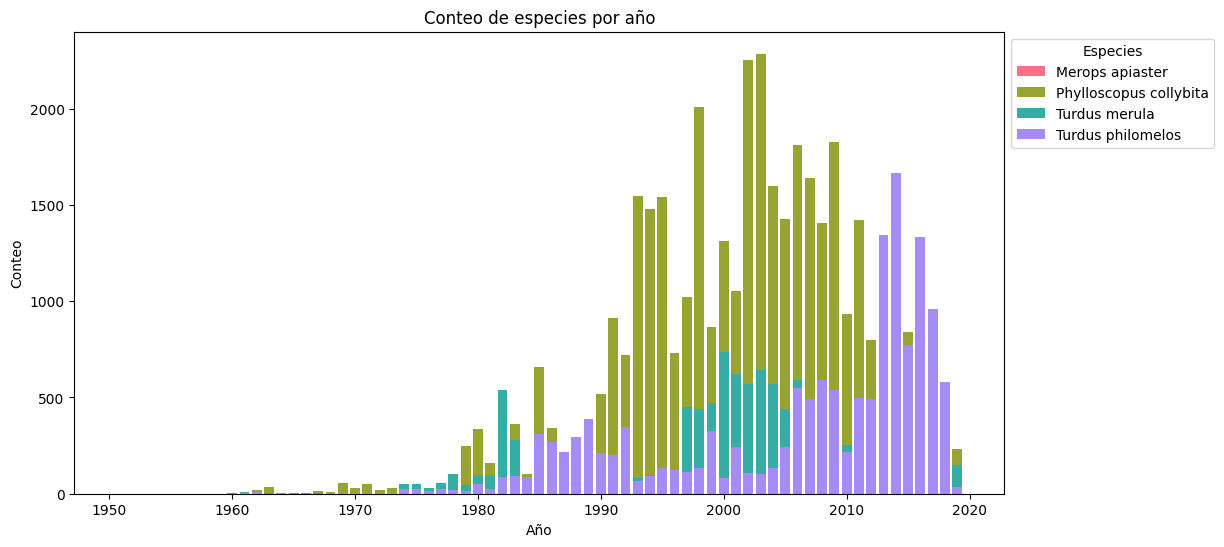

In [12]:
### 2.1. Conteo de especies por año
import matplotlib.pyplot as plt
import seaborn as sns

# Crear una paleta de colores única basada en todas las especies
paleta_colores = sns.color_palette('husl', n_colors=len(grouped_year_df['species'].unique()))
# Mapear cada especie a un color específico
especies_a_colores = dict(zip(grouped_year_df['species'].unique(), paleta_colores))

# Conteo de especies por año
plt.figure(figsize=(12, 6))
for species, data in grouped_year_df.groupby('species'):
    plt.bar(data['year'], data['count'], label=species, color=especies_a_colores[species])
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de especies por año')
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()

### 2.2. Conteo de especies por provincia en los años 2018 al 2019

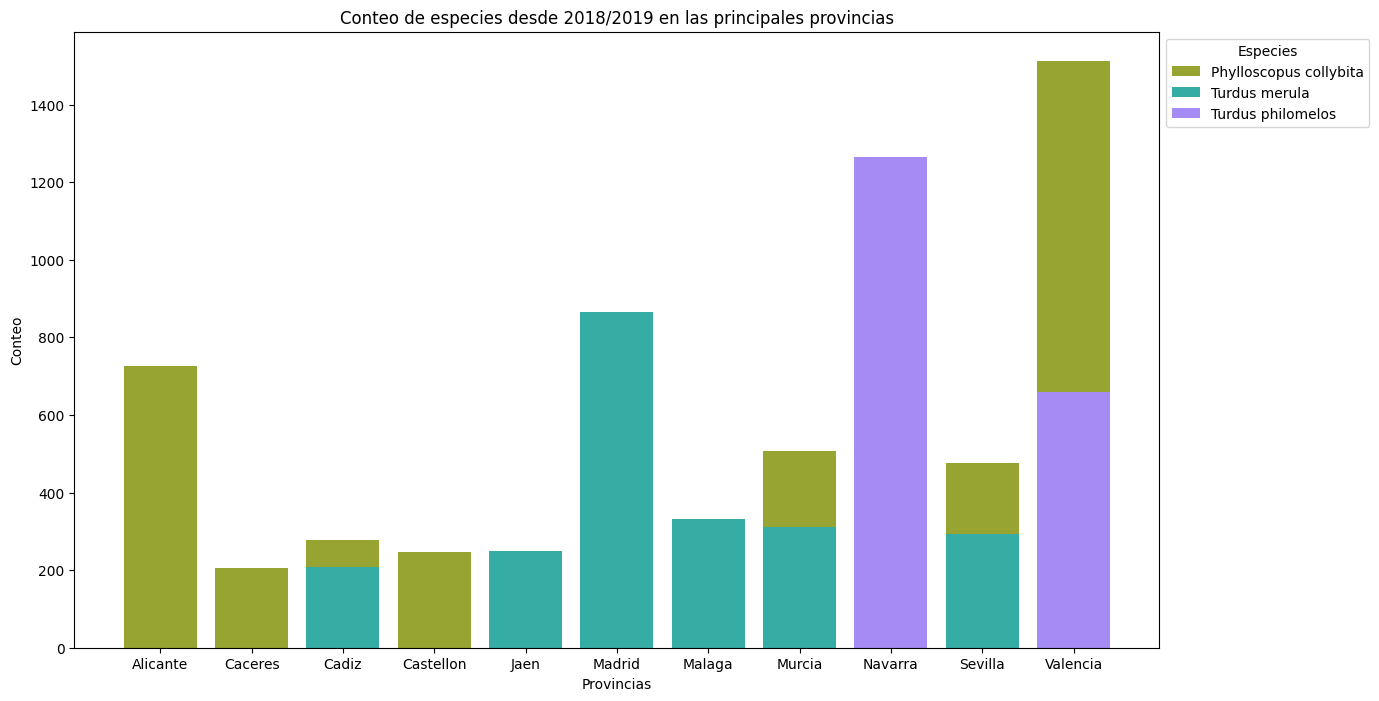

In [7]:
### 2.2. Conteo de especies por provincia en los años 2018 al 2019
plt.figure(figsize=(14, 8))
rango_anos = range(2018, 2019)
df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 200)]

for species, data in df_filtrado.groupby('species'):
    plt.bar(data['stateProvince'], data['count'], label=species, color=especies_a_colores[species])
plt.xlabel('Provincias')
plt.ylabel('Conteo')
plt.title('Conteo de especies desde 2018/2019 en las principales provincias')
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()

### 2.3. Estacionalidad - Conteo de especies por meses

Con la siguiente visualización, observamos que ciertas especies solo están presentes en ciertos momentos del año en España. Esto significa que nuestra serie temporal tendrá un componente estacional anual.


In [13]:
### 2.3. Estacionalidad - Conteo de especies por meses
plt.figure(figsize=(12, 6))
for species, data in grouped_month_df.groupby('species'):
    plt.bar(data['month'], data['count'], label=species, color=especies_a_colores[species])
plt.xlabel('Mes del año')
plt.ylabel('Conteo')
plt.title('Estacionalidad - Conteo de especies por meses del año')
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()

KeyboardInterrupt: 

## 3.Turdus merula : Mirlo

### 3.1. Conteo de Mirlo por año

In [ ]:
## 3.Turdus merula ("Mirlo")
## Estudio de observaciones sobre Turdus merula ("Mirlo")
especie = 'Turdus merula'
nombre_comun = 'Mirlo'
df_filtrado = grouped_year_df[grouped_year_df['species'] == especie]
    
### 3.1. Conteo de Mirlo por año
plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['year'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por año')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()


### 3.2.Conteo de Mirlo por provincia

In [ ]:
### 3.2. Conteo de Mirlo por provincia
rango_anos = (2018,2019)
df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 200)]

plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['stateProvince'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Provincia')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por provincia en 2019')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

## 5.Phylloscopus collybita: Mosquitero común
### 5.1. Conteo de Mosquitero común por año
### 5.2. Conteo de Mosquitero común por provincia

In [ ]:
#Estudio de Phylloscopus collybita ("Mosquitero común")
especie = 'Phylloscopus collybita'
nombre_comun = 'Mosquitero comun'
df_filtrado = grouped_year_df[grouped_year_df['species'] == especie]
    
### 3.1. Conteo de Mosquitero por año
plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['year'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por año')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 200)]

plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['stateProvince'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Provincia')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por provincia en 2019')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

## 6.Turdus philomelos: Zorzal común
### 6.1. Conteo de Zorzal común por año
### 6.2. Conteo de Zorzal común por provincia

In [ ]:

#Estudio de Turdus philomelos ("Zorzal común") 
especie = 'Turdus philomelos'
nombre_comun = 'Zorzal común'

df_filtrado = grouped_year_df[grouped_year_df['species'] == especie]
    
### 3.1. Conteo de Mirlo por año
plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['year'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por año')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 200)]

plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['stateProvince'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Provincia')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por provincia en 2019')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

# 7.Predicción series temporales

Debido a que las series temporales no pueden manejar predicciones espacio-temporales, seleccionamos una especie y una ubicación para modelar. Para seleccionar la ubicación, queremos asegurarnos de que tenga una buena cantidad de datos a lo largo de varios años. La siguiente visualización nos ayuda con esta decisión.

/var/folders/dx/9xjdddhn30jfw1p92r0hl5gh0000gn/T/ipykernel_68685/336414536.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_month_df_top_loc['date'] = pd.to_datetime(grouped_month_df_top_loc[['year', 'month']].assign(DAY=1))


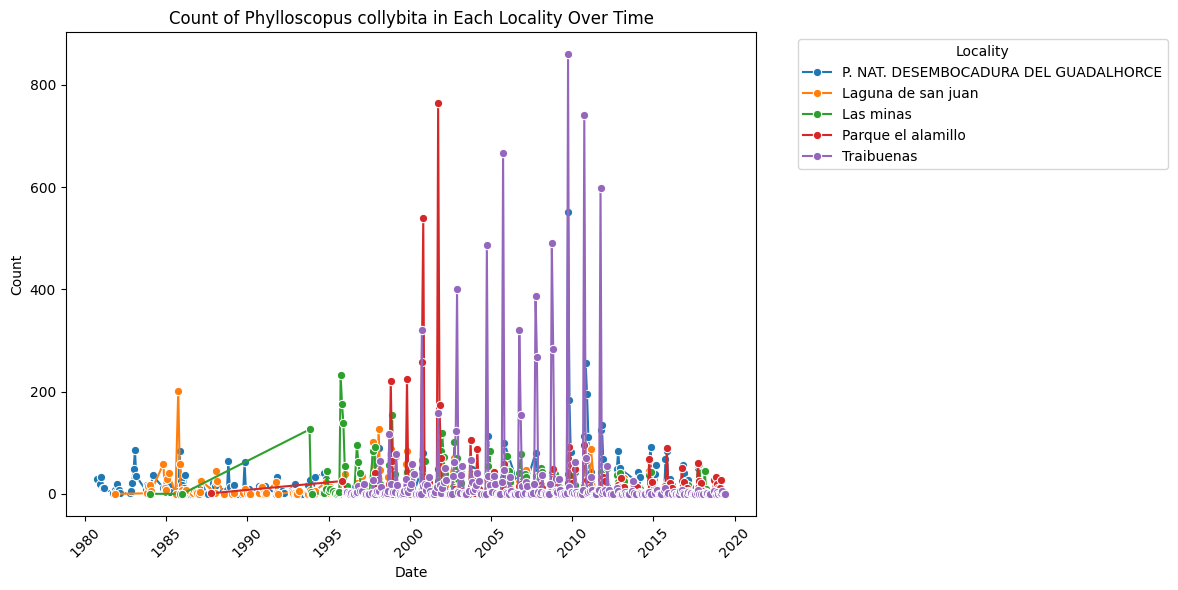

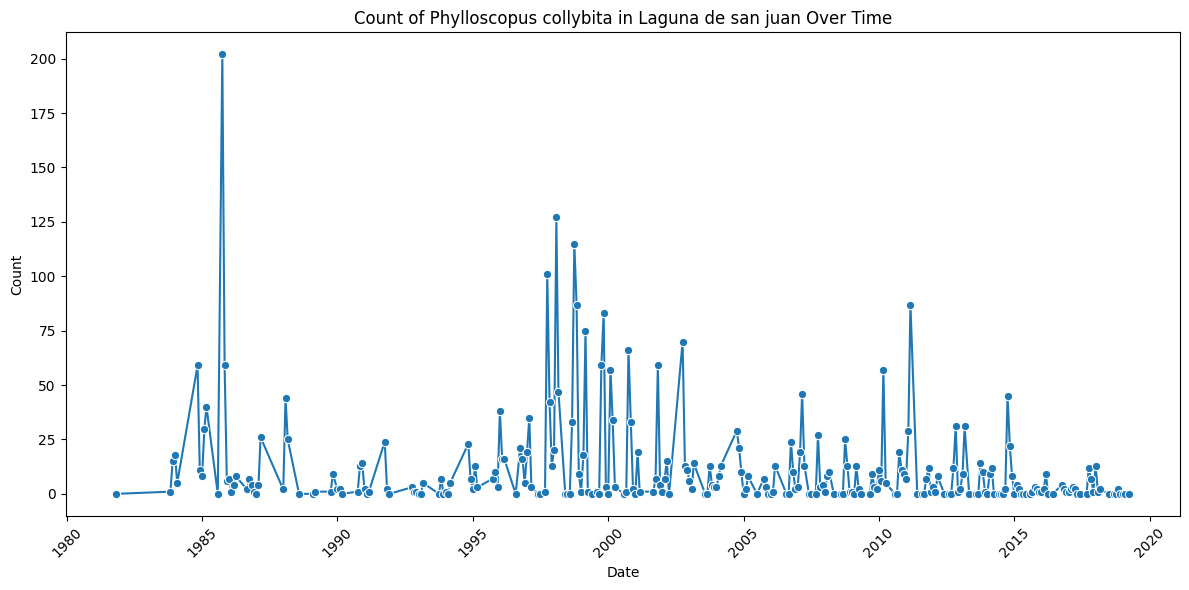

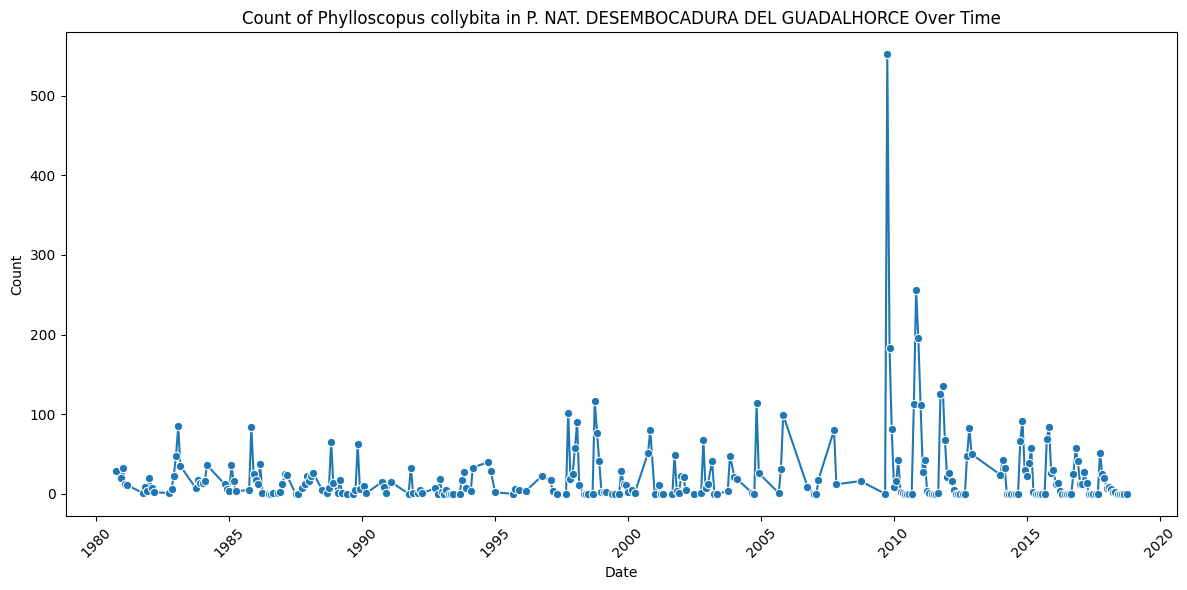

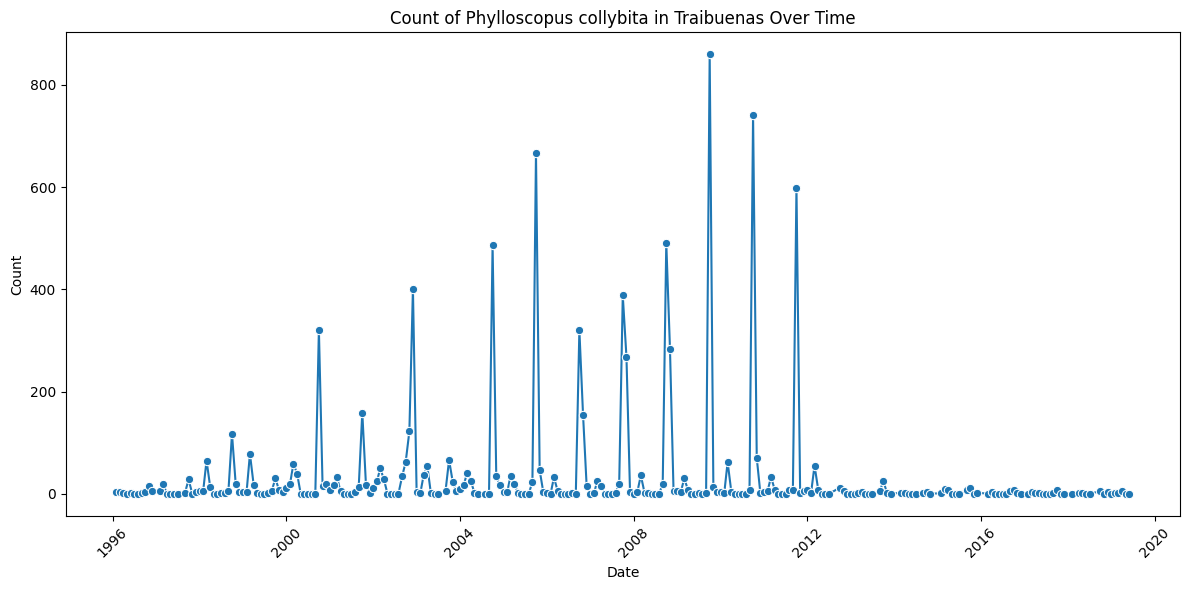

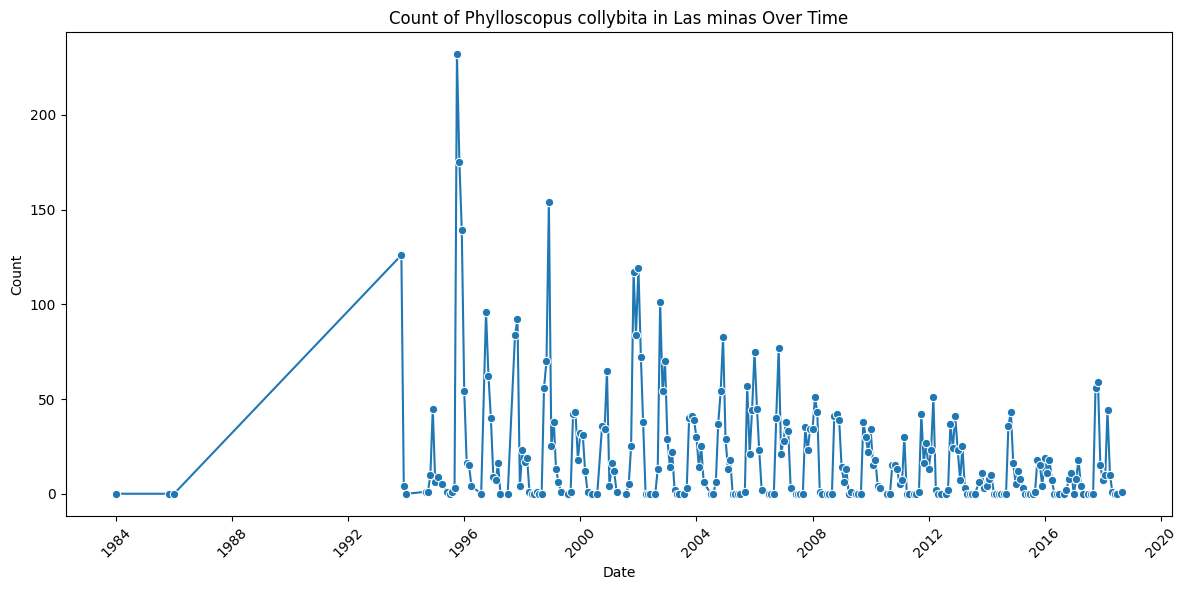

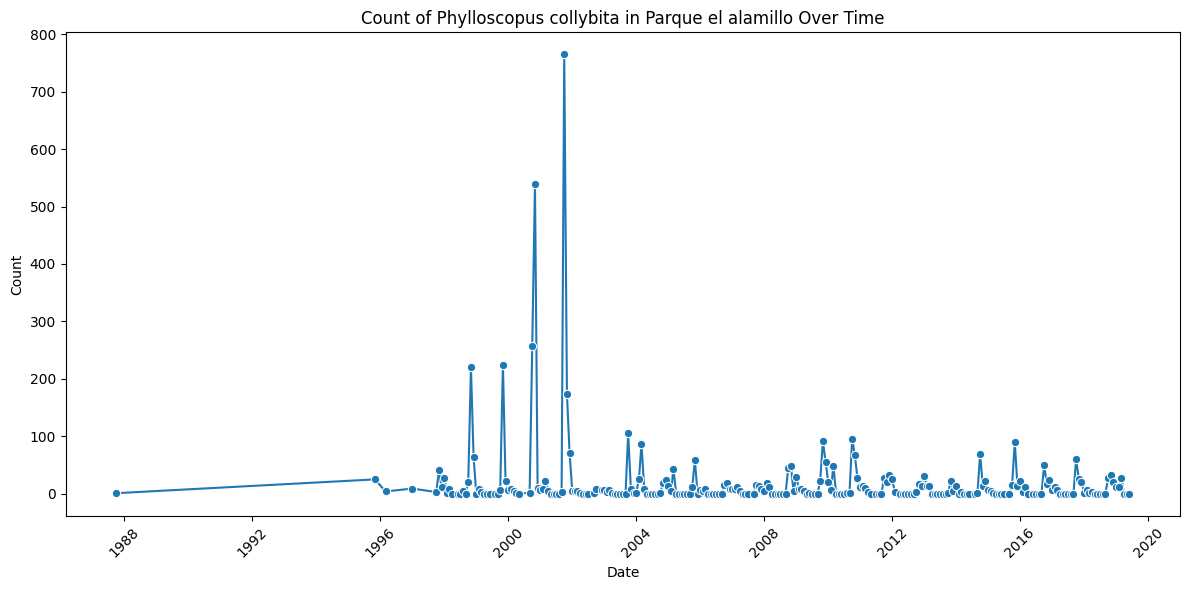

Locality with the most data: Laguna de san juan


In [19]:

species_to_visualize = "Phylloscopus collybita"
species_data_month = grouped_month_df[grouped_month_df['species'] == species_to_visualize]

locality_counts = species_data_month['locality'].value_counts()

# Get the 5 most common localities
top_localities = locality_counts.nlargest(5)

# List the names and counts of the top localities
grouped_month_df_top_loc = species_data_month[species_data_month['locality'].isin(top_localities.index)]
grouped_month_df_top_loc['date'] = pd.to_datetime(grouped_month_df_top_loc[['year', 'month']].assign(DAY=1))

# Filter data for the selected species
species_data = grouped_month_df_top_loc[grouped_month_df_top_loc['species'] == species_to_visualize]

# Plot the count in each location over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='count', hue='locality', data=species_data, marker='o')
plt.title(f'Count of {species_to_visualize} in Each Locality Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Locality', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

for cld in top_localities.index:
    chosen_locality_data = species_data[species_data['locality'] == cld]

    # Plot the count for the chosen locality
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='date', y='count', data=chosen_locality_data, marker='o')
    plt.title(f'Count of {species_to_visualize} in {chosen_locality_data["locality"].iloc[0]} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

print(f"Locality with the most data: {top_localities.idxmax()}")
max_locality = top_localities.idxmax()

We will create a model for the chiffchaff in this locality. The following dataset is what we will feed into our model:

/var/folders/dx/9xjdddhn30jfw1p92r0hl5gh0000gn/T/ipykernel_68685/3563491260.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['date'] = pd.to_datetime(grouped_month_df_mean[['year', 'month']].assign(DAY=1))


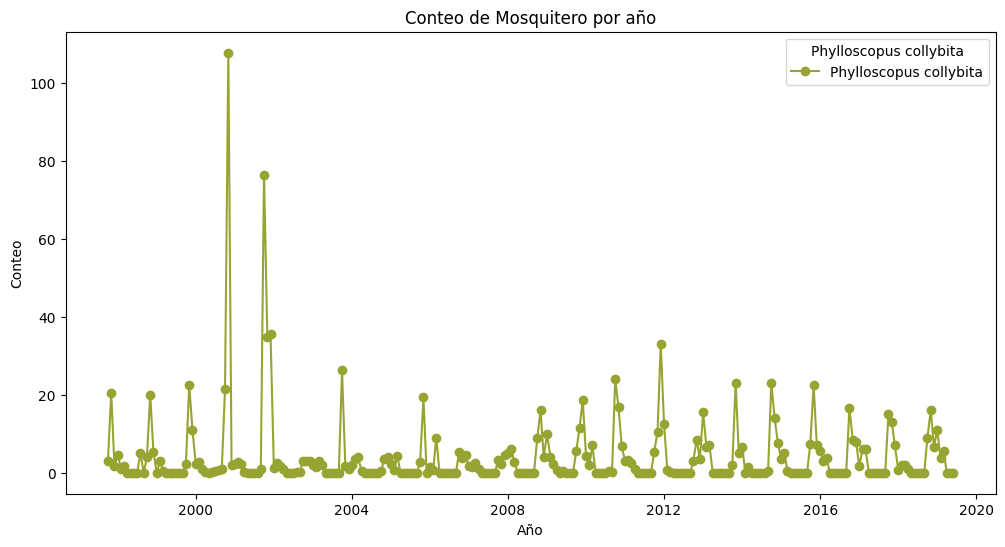

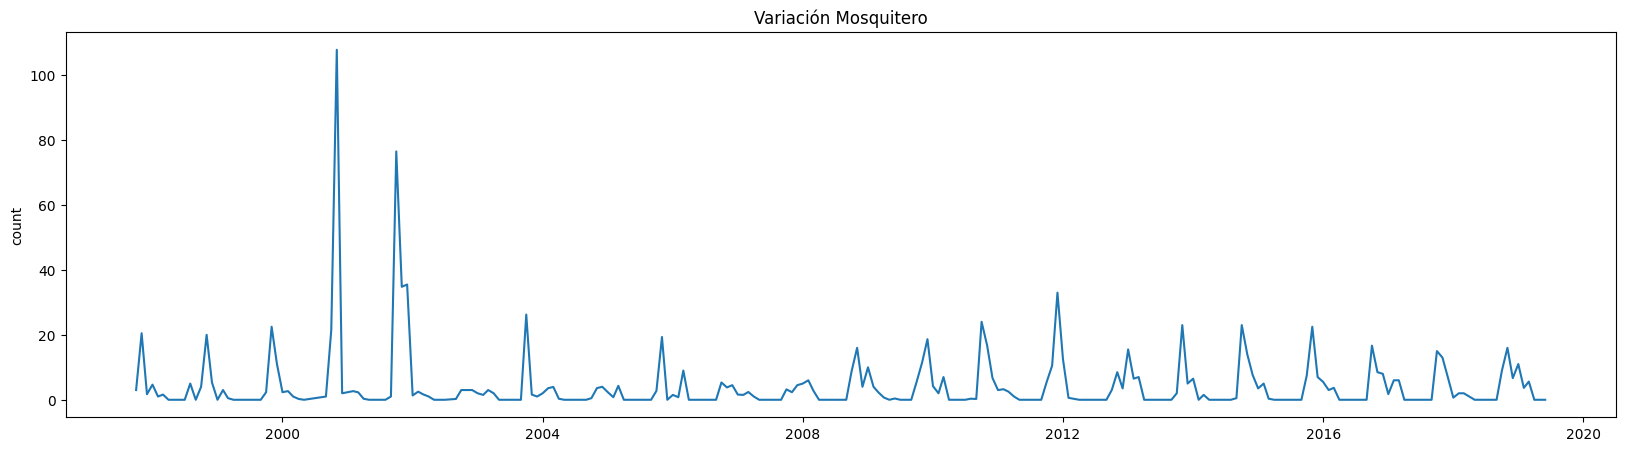

In [28]:
especie = 'Phylloscopus collybita'
nombre_comun = 'Mosquitero'
locality = "Parque el alamillo"
# Get the average rate of ringing for this bird in this locality
grouped_month_df_mean = grouped_eventDate_df.groupby(['species', 'month', 'year', 'locality']).mean('count').reset_index()
grouped_month_df_mean = grouped_month_df_mean.filter(items=['species', 'month', 'year', 'locality', 'count'])

df_filtrado = grouped_month_df_mean[(grouped_month_df['species'] == especie) & (grouped_month_df_mean['locality'] == locality)]
df_filtrado['date'] = pd.to_datetime(grouped_month_df_mean[['year', 'month']].assign(DAY=1))
df_filtrado = df_filtrado.sort_values(by='date')
df_filtrado = df_filtrado[df_filtrado['date'] > '1997-01-01']

datos = df_filtrado.sort_values(by='date')
datos = datos.drop('species', axis=1)
datos = datos.drop('locality', axis=1)
datos = datos.set_index('date')

# Define the month frequency
start_date = datos.index.min()
end_date = datos.index.max()
new_dates = pd.date_range(start=start_date, end=end_date, freq='MS')
new_datos = pd.DataFrame(index=new_dates)
datos = new_datos.merge(datos, how='left', left_index=True, right_index=True)

# Interpolate by mean on missing data
datos['count'].interpolate(method='linear', limit_direction='both', inplace=True)


plt.figure(figsize=(12, 6))
plt.plot(datos.index, datos['count'], marker='o', color=especies_a_colores[especie], label=especie)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de ' + nombre_comun + ' por año')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
plt.show()

def trazar(datos, rotacion=0, desde=None, hasta=None, figsize=(20, 5), title=''):
    plt.figure(figsize=figsize)
    if desde is None:
        desde = datos.index.min()
    else:
        desde = pd.to_datetime(desde, format='%d/%m/%Y')
    if hasta is None:
        hasta = datos.index.max()
    else:
        hasta = pd.to_datetime(hasta, format='%d/%m/%Y')
    
    datos=datos[(datos.index>=desde)&(datos.index<=hasta)]
    sns.lineplot(data=datos)
    plt.xticks(rotation=rotacion)
    plt.title(title)
    plt.show()
    
trazar(datos['count'], title="Variación Mosquitero")

Podemos observar que a principios de la década de 2000 se anillaron muchas más aves que en otros años, por lo que suavizamos estos años atípicos:

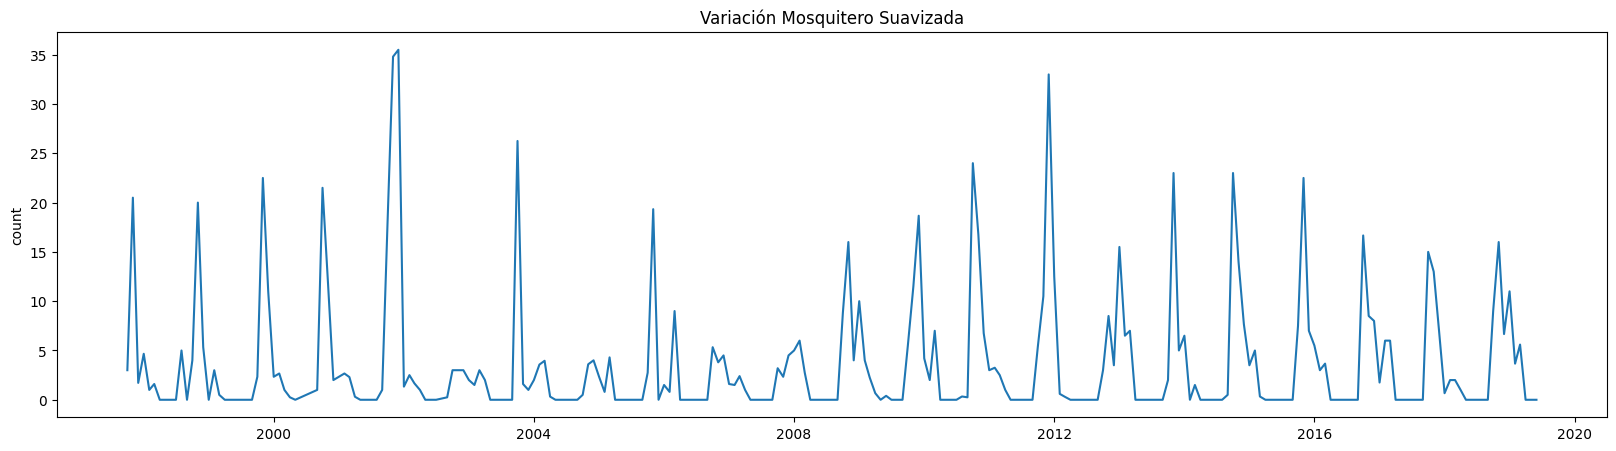

In [29]:
# Smooth the data; interpolate on data whose zscore is >= umbral_zscore
def suavizar_outliers(datos, umbral_zscore=3):
    df = pd.DataFrame({'serie':datos})   
    df['zscore'] = stats.zscore(datos).abs()
    df.loc[df['zscore'] >= umbral_zscore, 'serie'] = np.nan
    df['serie'] = df['serie'].interpolate(method='linear')  # Interpolate missing values
    return df['serie']

datos_smoothed= datos.copy()
datos_smoothed['count'] = suavizar_outliers(datos['count'],4)
trazar(datos_smoothed['count'], title="Variación Mosquitero Suavizada")


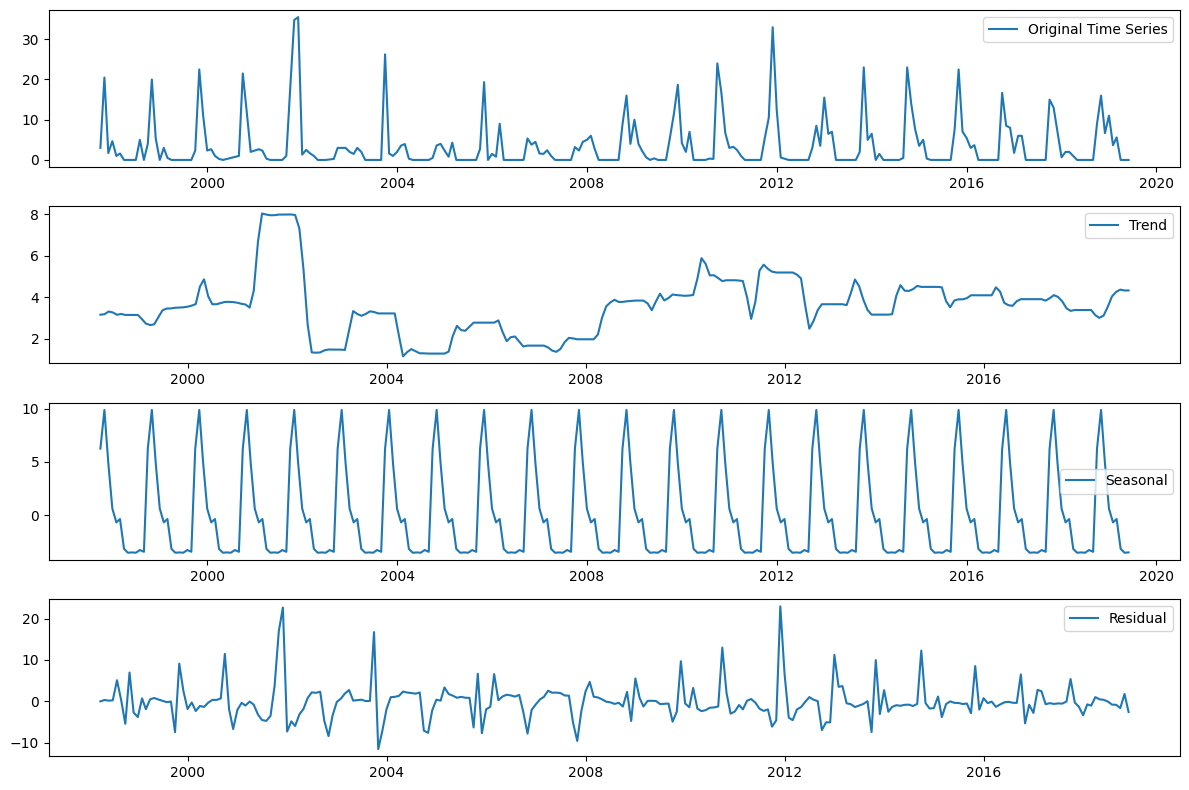

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

# # Perform seasonal decomposition
result = seasonal_decompose(datos_smoothed['count'], model='additive', period=12)

# Plot the original time series, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(datos_smoothed['count'], label='Original Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


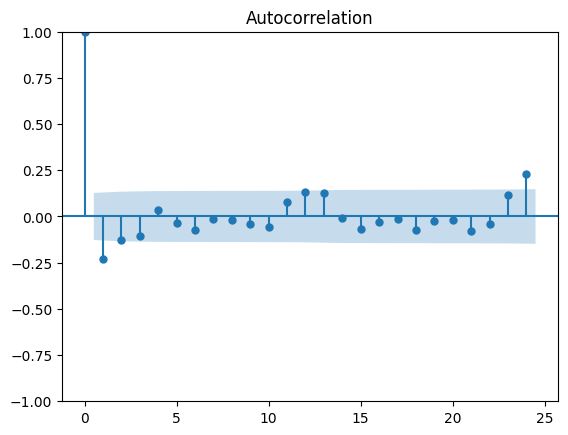

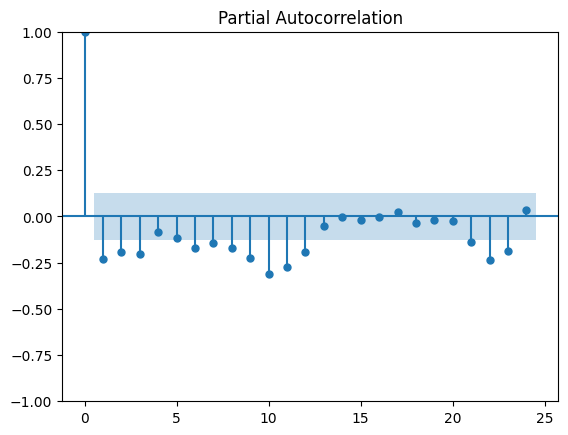

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07539D+00    |proj g|=  1.24492D-01

At iterate    5    f=  2.92290D+00    |proj g|=  4.26858D-02

At iterate   10    f=  2.90658D+00    |proj g|=  2.90294D-03

At iterate   15    f=  2.90542D+00    |proj g|=  2.55316D-03

At iterate   20    f=  2.90516D+00    |proj g|=  2.32609D-03

At iterate   25    f=  2.90486D+00    |proj g|=  7.86487D-04

At iterate   30    f=  2.90395D+00    |proj g|=  1.33772D-02

At iterate   35    f=  2.90316D+00    |proj g|=  2.55197D-03

At iterate   40    f=  2.90301D+00    |proj g|=  4.29282D-05

At iterate   45    f=  2.90301D+00    |proj g|=  1.18618D-03


/Users/daniellemckenney/Programming/erasmusCourses/ML/mlProjectsBirbs/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.90299D+00    |proj g|=  2.10109D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     55      1     0     0   2.101D-04   2.903D+00
  F =   2.9029894734120809     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


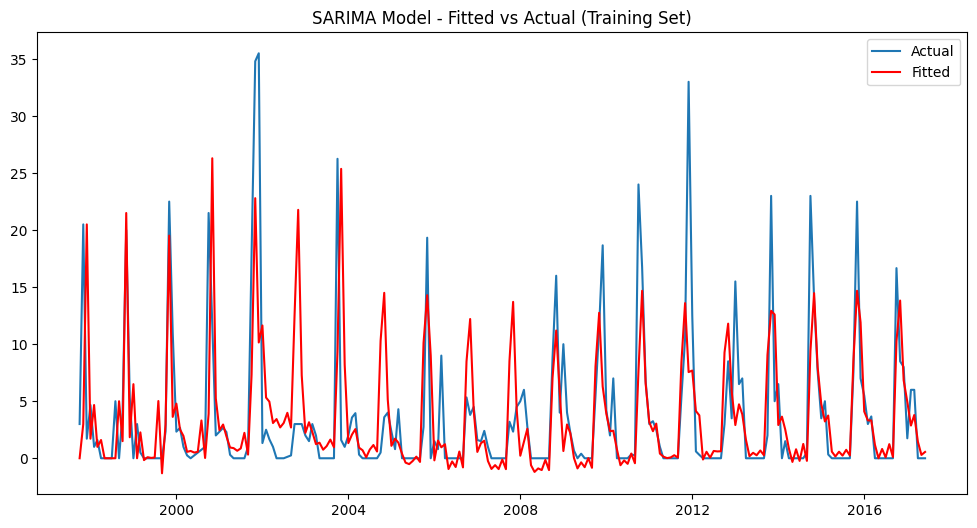

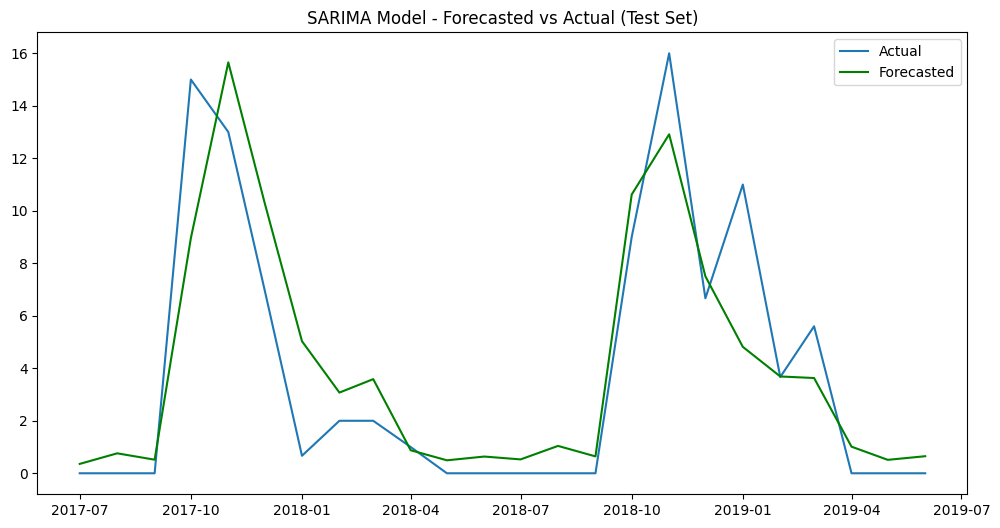

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit


test_size = 24 # two years of test data
train_data = datos_smoothed[:-test_size]
test_data = datos_smoothed[-test_size:]

# Determine the order of differencing
diff = train_data['count'].diff().dropna()

# Plot ACF and PACF to help determine the seasonal order
plot_acf(diff, lags=24)
plot_pacf(diff, lags=24)
plt.show()

order = (2, 1, 2)  # Replaced with appropriate values based on ACF and PACF analysis
seasonal_order = (2, 1, 2, 12)  # Assuming a yearly seasonality

# Create and fit the SARIMA model on the training data
sarima_model = SARIMAX(train_data['count'], order=order, seasonal_order=seasonal_order)
sarima_results = sarima_model.fit()

# Plot predicted vs actual values for the training set
plt.figure(figsize=(12, 6))
plt.plot(train_data['count'], label='Actual')
plt.plot(sarima_results.fittedvalues, label='Fitted', color='red')
plt.title('SARIMA Model - Fitted vs Actual (Training Set)')
plt.legend()
plt.show()

# Forecast on the test set
forecast = sarima_results.get_forecast(steps=test_size)

# Plot predicted vs actual values for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_data['count'], label='Actual')
plt.plot(forecast.predicted_mean, label='Forecasted', color='green')
plt.title('SARIMA Model - Forecasted vs Actual (Test Set)')
plt.legend()
plt.show()


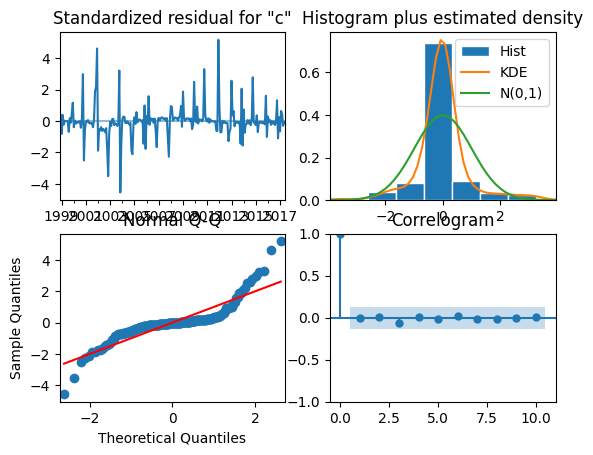

Mean Absolute Error: 1.67
Mean Squared Error: 5.73
Root Mean Squared Error: 2.39


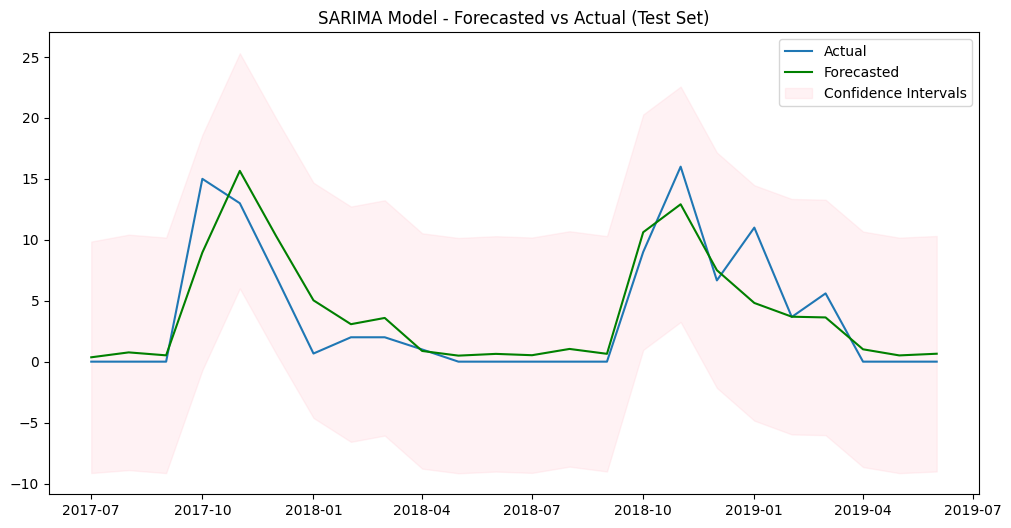

In [33]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error, mean_squared_error

sarima_results.plot_diagnostics()
plt.show()

# Forecast on the test set
forecast = sarima_results.get_forecast(steps=test_size)

# Extract actual values from the test set
actual_values = test_data['count']

# Extract forecasted values and associated confidence intervals
forecasted_values = forecast.predicted_mean
ci_lower = forecast.conf_int()['lower count']
ci_upper = forecast.conf_int()['upper count']

# Calculate metrics
mae = mean_absolute_error(actual_values, forecasted_values)
mse = mean_squared_error(actual_values, forecasted_values)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

# You may also print or visualize the forecast with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual')
plt.plot(forecasted_values, label='Forecasted', color='green')
plt.fill_between(actual_values.index, ci_lower, ci_upper, color='pink', alpha=0.2, label='Confidence Intervals')
plt.title('SARIMA Model - Forecasted vs Actual (Test Set)')
plt.legend()
plt.show()



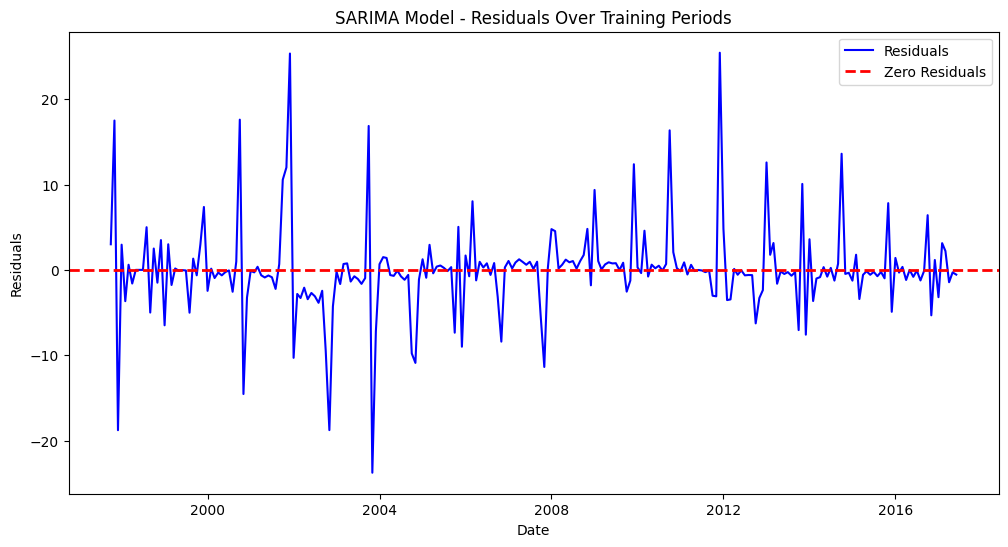

In [35]:
residuals = sarima_results.resid

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, residuals, label='Residuals', color='blue')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Residuals')
plt.title('SARIMA Model - Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()